In [1]:
#Pre-processing
#Taking only Dec data with source, destination and mean travel times
import numpy as np
with open('Datasets/Uber/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', 'r') as f1, open('Datasets/Uber/relevant_la_dec', 'w') as f2:
    for line in f1:
        arr = line.split(',')
        if arr[2] == '12':
            f2.write(arr[0] + ',' + arr[1] + ',' + arr[3] + '\n')

In [2]:
path_time = {}
with open('Datasets/Uber/relevant_la_dec', 'r') as f3:
    for line in f3:
        arr = line.split(',')
        key1 = (arr[0], arr[1])
        key2 = (arr[1], arr[0])
        if key1 in path_time:
            path_time[key1].append(float(arr[2]))
        elif key2 in path_time:
            path_time[key2].append(float(arr[2]))
        else:
            path_time[key1] = [float(arr[2])]

In [3]:

with open('Datasets/Uber/edge_weight_la_dec', 'w') as f4:
    for k in path_time:
        avg_time = np.mean(path_time[k])
        if k[0]!=k[1]:
            f4.write(str(k[0]) + ' ' + str(k[1]) + ' ' + str(avg_time) + '\n')


In [4]:
#Finding coordinates based on the polygons

import igraph as ig
import json

g = ig.Graph.Read_Ncol(f = 'Datasets/Uber/edge_weight_la_dec', directed = False)
gcc = g.components().giant()

name_to_disname_loc = {}

with open('Datasets/Uber/los_angeles_censustracts.json', 'r') as f:
    data = json.loads(f.readline())
    features = data['features']
    for feature in features:
        latitude = 0.0
        longitude = 0.0
        if feature['geometry']['type']=='Polygon':
            coordinates = np.array(feature['geometry']['coordinates'][0])

            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        if feature['geometry']['type']=='MultiPolygon':
            coordinates = np.array(feature['geometry']['coordinates'][0][0])
            for coordinate in coordinates:
                latitude += coordinate[1]
                longitude += coordinate[0]
        latitude /= len(coordinates)
        longitude /= len(coordinates)
        
        name_to_disname_loc[feature['properties']['MOVEMENT_ID']] = (feature['properties']['DISPLAY_NAME'], latitude, longitude)



In [5]:
seq = gcc.vs()
for i in seq:
    i['display name'] = name_to_disname_loc[i['name']][0]
    i['location'] = (name_to_disname_loc[i['name']][1], name_to_disname_loc[i['name']][2])
ig.summary(gcc)

IGRAPH UNW- 2649 1003858 -- 
+ attr: display name (v), location (v), name (v), weight (e)


In [6]:
# Just for counting polygons and multipolygons
with open('Datasets/Uber/los_angeles_censustracts.json', 'r') as f:
    data = json.loads(f.readline())
    features = data['features']
    countp=0
    countmp=0
    for feature in features:
        if feature['geometry']['type']=='Polygon':
            coordinates = np.array(feature['geometry']['coordinates'][0])
            countp += 1
        if feature['geometry']['type']=='MultiPolygon':
            countmp += 1
print(countp)
print(countmp)

2576
140


In [7]:
#Q 11

from scipy.spatial import Delaunay
lat=[]
lon=[]
for i in range(1,len(name_to_disname_loc)+1):
    lat.append(name_to_disname_loc[str(i)][1])
    lon.append(name_to_disname_loc[str(i)][2])
lat_lon = tuple(zip(lat, lon)) 
tri = Delaunay(lat_lon)

In [8]:
import matplotlib.pyplot as plt
plt.triplot(lon, lat, tri.simplices)
plt.plot(lon, lat, 'o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')
plt.savefig('ECE232E_plots\Project4_plots\q11.png', bbox_inches='tight')
plt.show()


<Figure size 640x480 with 1 Axes>

In [9]:
# Q 13
malibu= [34.04, -118.56]
long_beach =  [33.77, -118.18]

# Distance based on internet : https://www.nhc.noaa.gov/gccalc.shtml 
# The distance is 28.6 miles

# Based on formula derived
dist=69*np.sqrt((malibu[0]-long_beach[0])**2+(malibu[1]-long_beach[1])**2)
print(dist)

32.16465917742598


In [10]:
# It is 32.16 mile
# Avg time from malibu to long beach = 1.05 hours = 3770.78 secs
v=dist/1.05 #miles/hour
traffic_flow=2*v/(0.003+v/1800)
print(traffic_flow)

3060.494677531579


In [11]:
#find nodes closest to given points
min_long_beach=10000
min_malibu=10000
long_beach_index=0
malibu_index=0
for i in range(1,len(name_to_disname_loc)+1):
    a=name_to_disname_loc[str(i)][1]
    b=name_to_disname_loc[str(i)][2]
    c=np.sqrt((a-long_beach[0])**2+(b-long_beach[1])**2)
    d=np.sqrt((malibu[0]-a)**2+(malibu[1]-b)**2)
    if c<min_long_beach:
        min_long_beach=c
        long_beach_index=i
    if d<min_malibu:
        min_malibu=d
        malibu_index=i
print(long_beach_index)
print(malibu_index)

672
1523


In [12]:
#Verifying if they care close to the coordinates provided
print(lon[1523], lat[1523])
print(lon[672], lat[672])

-118.54279579914532 34.043940760683725
-118.1739305238095 33.77154947619048


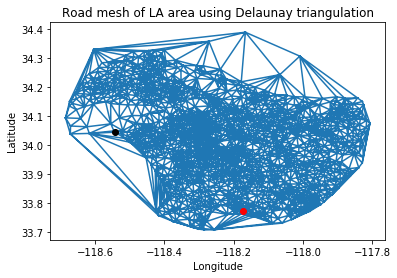

In [13]:
import matplotlib.pyplot as plt
plt.triplot(lon, lat, tri.simplices)
#plt.plot(lon, lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')
plt.plot(lon[1523], lat[1523],'o',color='black')
plt.plot(lon[672], lat[672],'o',color='red')
plt.savefig('ECE232E_plots\Project4_plots\q13_a.png', bbox_inches='tight')
plt.show()


In [14]:
#Making the delauney triangulation a graph
g_del=ig.Graph()
g_del.add_vertices(len(tri.points))
vert=g_del.vs()
i=0
for v in vert:
    v['lat']=lat[i]
    v['lon']=lon[i]
    i+=1

In [15]:
#generate edge pairs from the simplices information
duplicate_check=set()
for i in range(len(tri.simplices)):
    a=((tri.simplices[i][0], tri.simplices[i][1]))
    b=((tri.simplices[i][0], tri.simplices[i][2]))
    c=((tri.simplices[i][1], tri.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    if not a in duplicate_check:
        duplicate_check.add(a)
        g_del.add_edges([a])
    if not b in duplicate_check:
        duplicate_check.add(b)
        g_del.add_edges([b])
    if not c in duplicate_check:
        duplicate_check.add(c)
        g_del.add_edges([c])


In [16]:
#Checking degree
g_del.degree(1523)

5

In [17]:
#checking number of edge disjoint paths
g_del.adhesion(1523,672)

5

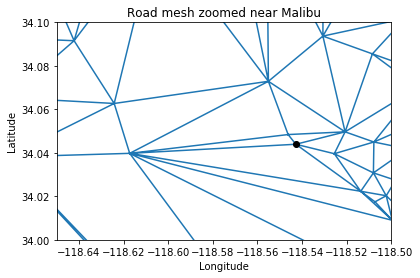

In [18]:
#zoom in on malibu
plt.triplot(lon, lat, tri.simplices)
#plt.plot(lon, lat)
plt.ylim(34,34.1)
plt.xlim(-118.65,-118.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh zoomed near Malibu')
plt.plot(lon[1523], lat[1523],'o',color='black')
plt.savefig('ECE232E_plots\Project4_plots\q13_b.png', bbox_inches='tight')
plt.show()
# malibu vertex has 5 degrees

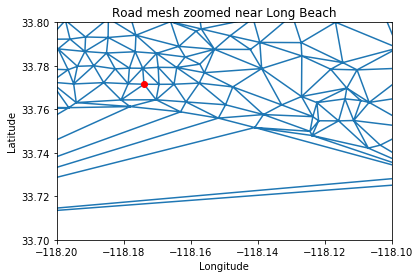

In [19]:
#zoom in on long beach
plt.triplot(lon, lat, tri.simplices)
#plt.plot(lon, lat)
plt.plot(lon[672], lat[672],'o',color='red')
plt.ylim(33.7,33.8)
plt.xlim(-118.2,-118.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh zoomed near Long Beach')
plt.savefig('ECE232E_plots\Project4_plots\q13_c.png', bbox_inches='tight')
plt.show()
#long beach vertex has 5 degrees

In [20]:
#Q 14
# Find the mean and standard deviation of the mean travel times

edges=gcc.es()
tot=[]
for edge in edges:
    tot.append(edge['weight'])
tot_arr=np.array(tot)
avg=np.mean(tot_arr)
std=np.std(tot_arr)
print(avg)
print(std)

1496.788687707823
638.8131092856843


In [21]:
# The time considered is 1496.78 + 638.81 sec = 0.6 hours
# Veloctiy is 32 miles/hr based on Q 13
# Therefore, max stretch of road is 19.2 miles

g_del_mod=ig.Graph()
g_del_mod.add_vertices(len(tri.points))
vert=g_del_mod.vs()
i=0
for v in vert:
    v['lat']=lat[i]
    v['lon']=lon[i]
    i+=1

#define coordinate threshold
thres=(19.2/69)
#if distance between coordinates is greater than this, edge should not exist
    
#generate edge pairs from the simplices information
duplicate_check=set()
edge_cut=set()
for i in range(len(tri.simplices)):
    a=((tri.simplices[i][0], tri.simplices[i][1]))
    b=((tri.simplices[i][0], tri.simplices[i][2]))
    c=((tri.simplices[i][1], tri.simplices[i][2]))
    list(a).sort()
    list(b).sort()
    list(c).sort()
    #print(a,b,c)
    if not a in duplicate_check:
        duplicate_check.add(a)
        a_check=np.sqrt((vert[a[0]]['lat']-vert[a[1]]['lat'])**2+(vert[a[0]]['lon']-vert[a[1]]['lon'])**2)
        if a_check<thres:
            g_del_mod.add_edges([a])
        else:
            edge_cut.add(a)
    if not b in duplicate_check:
        duplicate_check.add(b)
        b_check=np.sqrt((vert[b[0]]['lat']-vert[b[1]]['lat'])**2+(vert[b[0]]['lon']-vert[b[1]]['lon'])**2)
        if b_check<thres:
            g_del_mod.add_edges([b])
        else:
            edge_cut.add(b)
    if not c in duplicate_check:
        duplicate_check.add(c)
        c_check=np.sqrt((vert[c[0]]['lat']-vert[c[1]]['lat'])**2+(vert[c[0]]['lon']-vert[c[1]]['lon'])**2)
        if c_check<thres:
            g_del_mod.add_edges([c])
        else:
            edge_cut.add(c)

In [22]:
#set of edges that will be removed
edge_cut

{(1710, 2448),
 (1710, 2449),
 (1711, 2448),
 (2448, 1710),
 (2471, 2470),
 (2473, 2471)}

In [23]:
edge_cut_list=list(edge_cut)
simp_list=[]
for simp in tri.simplices:
    for edge in edge_cut_list:
        if edge[0] in simp and edge[1] in simp:
            simp1=list(simp)
            simp_list.append(simp1)

In [24]:
simp_arr=np.array(simp_list)
rex = [i for i in tri.simplices if i not in simp_arr]

5407


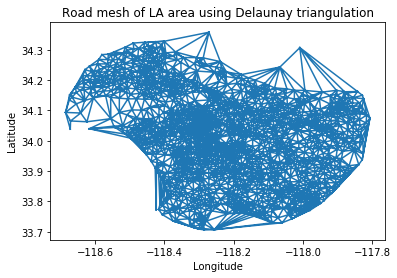

In [25]:
print(len(tri.simplices))
plt.triplot(lon, lat, rex)
#plt.plot(lon, lat, 'o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')
plt.savefig('ECE232E_plots\Project4_plots\q14.png', bbox_inches='tight')
plt.show()

In [26]:
#Q15
g_del_mod.degree(1523)

5

In [27]:
g_del_mod.adhesion(1523,672)

5

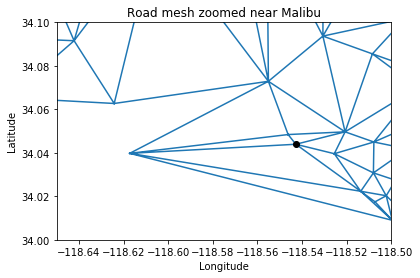

In [28]:
#zoom in on malibu
plt.triplot(lon, lat, rex)
#plt.plot(lon, lat)
plt.ylim(34,34.1)
plt.xlim(-118.65,-118.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh zoomed near Malibu')
plt.plot(lon[1523], lat[1523],'o',color='black')

plt.show()
plt.show()
# malibu vertex has 5 degrees

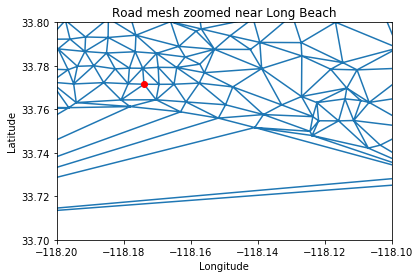

In [29]:
#zoom in on long beach
plt.triplot(lon, lat, rex)
#plt.plot(lon, lat)
plt.plot(lon[672], lat[672],'o',color='red')
plt.ylim(33.7,33.8)
plt.xlim(-118.2,-118.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh zoomed near Long Beach')
plt.savefig('ECE232E_plots\Project4_plots\q15_b.png', bbox_inches='tight')
plt.show()
#long beach vertex has 5 degrees

NameError: name 'Basemap' is not defined

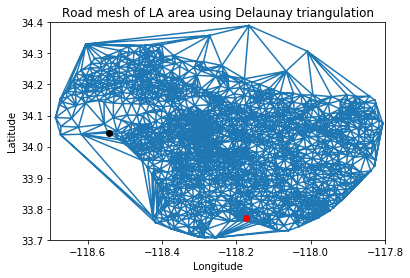

In [30]:
#Trying basemap
import matplotlib.pyplot as plt
plt.triplot(lon, lat, tri.simplices)
#plt.plot(lon, lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')
plt.plot(lon[1523], lat[1523],'o',color='black')
plt.plot(lon[672], lat[672],'o',color='red')
plt.xlim(-118.7,-117.8)
plt.ylim(33.7,34.4)

m = Basemap(llcrnrlon=-118.7,llcrnrlat=33.7,urcrnrlon=-117.8,urcrnrlat=34.4,resolution='h',projection='merc')

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
plt.show()


In [ ]:
#basemap with the G_delta graph
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure()

# setup mercator map projection.
m = Basemap(llcrnrlon=-118.7,llcrnrlat=33.7,urcrnrlon=-117.8,urcrnrlat=34.4,resolution='f',projection='merc')

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')

for i in range(len(tri.points)):
    lon1 = lon[i]
    lat1 = lat[i]
    x,y = m(lon1, lat1)
    m.plot(x, y, 'go', markersize=2)
    
edges=g_del.es()
vert=g_del.vs()
for edge in edges:
    lat1=vert[edge.tuple[0]]['lat']
    lat2=vert[edge.tuple[1]]['lat']
    lon1=vert[edge.tuple[0]]['lon']
    lon2=vert[edge.tuple[1]]['lon']
    lon3=[lon1,lon2]
    lat3=[lat1,lat2]
    x, y = m(lon3, lat3)
    m.plot(x, y, 'b-', markersize=1, linewidth=1)
    
plt.savefig('ECE232E_plots\Project4_plots\q14_b.png', bbox_inches='tight')
plt.show()

In [ ]:
#basemap with the G_delta_tilda graph
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

fig=plt.figure()

# setup mercator map projection.
m = Basemap(llcrnrlon=-118.7,llcrnrlat=33.7,urcrnrlon=-117.8,urcrnrlat=34.4,resolution='f',projection='merc')

m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road mesh of LA area using Delaunay triangulation')

for i in range(len(tri.points)):
    lon1 = lon[i]
    lat1 = lat[i]
    x,y = m(lon1, lat1)
    m.plot(x, y, 'go', markersize=2)
    
edges=g_del_mod.es()
vert=g_del_mod.vs()
for edge in edges:
    lat1=vert[edge.tuple[0]]['lat']
    lat2=vert[edge.tuple[1]]['lat']
    lon1=vert[edge.tuple[0]]['lon']
    lon2=vert[edge.tuple[1]]['lon']
    lon3=[lon1,lon2]
    lat3=[lat1,lat2]
    x, y = m(lon3, lat3)
    m.plot(x, y, 'b-', markersize=1, linewidth=1)
    
plt.savefig('ECE232E_plots\Project4_plots\q14_c.png', bbox_inches='tight')
    

plt.show()